- UK に限定して分析を進める。
  - 売上改善施策は、
    - UK
    - UK 以外
  - で考えられる。UK 以外は 課題A で挙げている国に限定する。

In [79]:
import time 

from IPython.core.display import display
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
plt.style.use('ggplot')
import numpy as np
import seaborn as sns
sns.set(font='Osaka')
import pandas as pd

Load in  1.8284239768981934


In [ ]:
t0 = time.time()
data_dir = '../data/'
file = 'df_item_transaction.csv'
df_item_transaction = pd.read_csv(data_dir + file)
print('Load in ', time.time() - t0)

In [2]:
country = 'United Kingdom'
df_uk = \
df_item_transaction[df_item_transaction['Country'] == country].drop('Unnamed: 0', axis=1)

# CustomerID to Nominal
df_uk['CustomerID'] = df_uk['CustomerID'].fillna('NaN')

# InvoiceDate to Datetime
df_uk['InvoiceDate'] = pd.to_datetime(df_uk['InvoiceDate'])

print(df_uk.dtypes)
display(df_uk.head())

InvoiceNo               int64
StockCode              object
Description            object
Quantity                int64
InvoiceDate    datetime64[ns]
UnitPrice             float64
CustomerID             object
Country                object
Sales                 float64
dtype: object


,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country,Sales
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850,United Kingdom,15.30
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850,United Kingdom,22.00
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850,United Kingdom,20.34


In [4]:
assert df_uk['StockCode'].nunique() == 3910
assert df_uk['CustomerID'].nunique() == 3918

print('# of distinct items =', df_uk['StockCode'].nunique())
print('# of distinct customers =', df_uk['CustomerID'].nunique())

# of distinct items = 3910
# of distinct customers = 3918


In [77]:
# Customer ごとにデータを集計　
# Recency
# Frequency = #ofTransactions
# Monetary = sum(Sales)

# Sales: min, max, median, mean, sum
# Quantity: min, max, median, mean, sum
# Quantity / Transaction: min, max, median, mean
# Unitprice: min, max, median, mean

# Item / Transaction = 商品の種類 / Transaction: min, max, median, mean


# 各商品をいくつ購入したか？　(3,910 items hence the same # of columns)

# TODO:
# ある商品を購入する顧客は Frequency が大きいといった関係が発見できるか？
# RMF 分析で優良顧客を見つけ出し、彼らの 2月, 4月の


# Monetary
df_uk_per_customer = \
pd.DataFrame(df_uk.groupby('CustomerID')['Sales'].sum()).reset_index()\
.rename(columns={'Sales': 'Monetary'})

# Frequency
df_uk_per_customer['Frequency'] = \
pd.DataFrame(df_uk.groupby('CustomerID')['InvoiceNo'].nunique()).reset_index()['InvoiceNo']
# small test
test_customer = 12748
assert df_uk_per_customer[df_uk_per_customer['CustomerID'] == test_customer]['Frequency'].values\
            == df_uk[df_uk['CustomerID'] == test_customer]['InvoiceNo'].nunique()

# Recency
# 基準日
df_uk_per_customer['ReferenceDate'] = \
    pd.to_datetime(df_item_transaction['InvoiceDate']).max()
# 最終購入日
df_uk_per_customer['LastTransactionDate'] = \
    pd.DataFrame(df_uk.groupby('CustomerID')['InvoiceDate'].max()).reset_index()['InvoiceDate']
# 基準日 - 最終購入日
df_uk_per_customer['Recency(Day)'] = \
(df_uk_per_customer['ReferenceDate'].dt.date - df_uk_per_customer['LastTransactionDate'].dt.date).dt.days


display(df_uk_per_customer.head())

,CustomerID,Monetary,Frequency,ReferenceDate,LastTransactionDate,Recency(Day)
0,12346,77183.60,1,2011-12-09 12:50:00,2011-01-18 10:01:00,325
1,12747,4196.01,11,2011-12-09 12:50:00,2011-12-07 14:34:00,2
2,12748,32317.32,206,2011-12-09 12:50:00,2011-12-09 12:20:00,0
3,12749,4040.88,5,2011-12-09 12:50:00,2011-12-06 09:56:00,3
4,12820,942.34,4,2011-12-09 12:50:00,2011-12-06 15:12:00,3


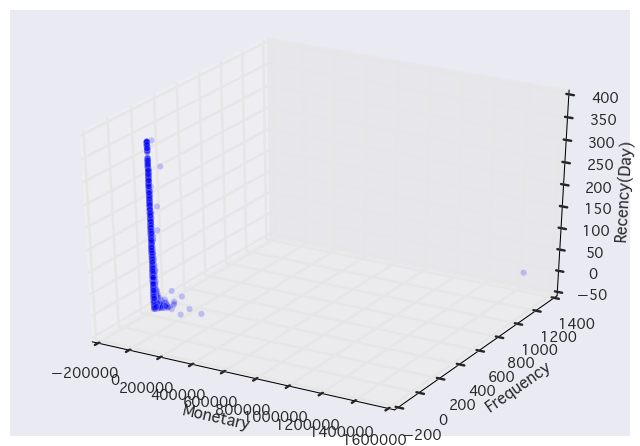

In [83]:
# 3D plot

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = 'Monetary'
y = 'Frequency'
z = 'Recency(Day)'
ax.scatter(
    xs=df_uk_per_customer[x], 
    ys=df_uk_per_customer[y], 
    zs=df_uk_per_customer[z],
    alpha=0.2
)
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)
plt.show()

# NOTE:
# Monetary と Frequency が飛び抜けているカスタマーがいる。

In [84]:
# Monetary と Frequency が飛び抜けているカスタマーの正体は、
# CustomerID = NaN

df_uk_per_customer.sort_values('Monetary', ascending=False).head()

,CustomerID,Monetary,Frequency,ReferenceDate,LastTransactionDate,Recency(Day)
3917,NaN,1482450.84,1324,2011-12-09 12:50:00,2011-12-09 10:26:00,0
3780,18102,259657.30,60,2011-12-09 12:50:00,2011-12-09 11:50:00,0
3312,17450,194550.79,46,2011-12-09 12:50:00,2011-12-01 13:29:00,8
2597,16446,168472.50,2,2011-12-09 12:50:00,2011-12-09 09:15:00,0
3354,17511,91062.38,31,2011-12-09 12:50:00,2011-12-07 10:12:00,2


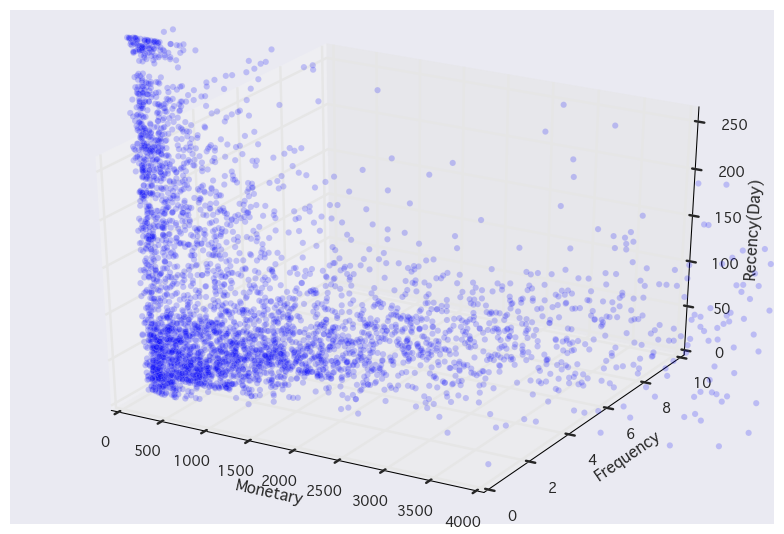

In [100]:
# 3D plot
# CustomerID = NaN を除外

df_plot = df_uk_per_customer[df_uk_per_customer['CustomerID'] != 'NaN']

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
x = 'Monetary'
y = 'Frequency'
z = 'Recency(Day)'
ax.scatter(xs=df_plot[x], ys=df_plot[y], zs=df_plot[z], alpha=0.2)
ax.set_xlim(0, 4000)
ax.set_ylim(0, 10)
ax.set_zlim(0, 260)
ax.set_xlabel(x)
ax.set_ylabel(y)
ax.set_zlabel(z)
plt.tight_layout()
plt.show()

# NOTE:
# Monetary と Frequency が小さいカスタマーの Recency は ばらついている。
# 一方、Monetary と Frequency が大きいカスタマーの Recency は それほどばらついていなく、それほど大きくもない。

In [98]:
df_uk_per_customer.describe(percentiles=[.25, .5, .75, .9])

,Monetary,Frequency,Recency(Day)
count,3.918000e+03,3918.000000,3918.000000
mean,2.232894e+03,4.572231,91.870087
std,2.479490e+04,22.266615,99.748296
min,3.750000e+00,1.000000,0.000000
25%,2.994050e+02,1.000000,17.000000
50%,6.504700e+02,2.000000,50.000000
75%,1.572290e+03,5.000000,143.000000
90%,3.408186e+03,9.000000,261.000000
max,1.482451e+06,1324.000000,373.000000
